In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,classification_report,average_precision_score,confusion_matrix
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

In [2]:
#pip install opencv-python

# Model 

In [3]:
def build_model(pretrained):
    model = Sequential([
        pretrained, #DenseNet169
        layers.GlobalAveragePooling2D(),
        #layers.Dense(64,activation='relu'),
        #layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )
    
    return model

# Generator

In [4]:
base_path = '/home/jovyan/work/real_vs_fake/real-vs-fake/'
image_gen = ImageDataGenerator(rescale=1./255.,
                               rotation_range=20,
                               #shear_range=0.2,
                               #zoom_range=0.2,
                               horizontal_flip=True)

train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 101081 images belonging to 2 classes.


In [5]:
train_flow.class_indices

{'fake': 0, 'real': 1}

In [6]:
image_gen1 = ImageDataGenerator(rescale=1./255.)

valid_flow = image_gen1.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


# Train Model DenseNet Augmented Data

In [7]:
densenet = DenseNet169(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(densenet)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________________________________


In [8]:
early_stop = EarlyStopping(monitor='val_loss',patience = 1)

In [9]:
train_steps = 100000//64
valid_steps = 20000//64

history = model.fit_generator(
    train_flow,
    epochs = 25,
    #callbacks=[early_stop],
    steps_per_epoch= train_steps,
    validation_data= valid_flow,
    validation_steps= valid_steps
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
1562/1562 [==============================] - 1612s 1s/step - loss: 0.5364 - accuracy: 0.7241 - val_loss: 0.5624 - val_accuracy: 0.7374
Epoch 2/25
1562/1562 [==============================] - 1308s 837ms/step - loss: 0.3741 - accuracy: 0.8338 - val_loss: 0.4695 - val_accuracy: 0.7769
Epoch 3/25
1562/1562 [==============================] - 1323s 847ms/step - loss: 0.2775 - accuracy: 0.8832 - val_loss: 0.5170 - val_accuracy: 0.7808
Epoch 4/25
1562/1562 [==============================] - 1330s 851ms/step - loss: 0.2107 - accuracy: 0.9139 - val_loss: 0.2739 - val_accuracy: 0.8883
Epoch 5/25
1562/1562 [==============================] - 1317s 843ms/step - loss: 0.1640 - accuracy: 0.9344 - val_loss: 0.4443 - val_accuracy: 0.8165
Epoch 6/25
1562/1562 [==============================] - 1308s 837ms/step - loss: 0.1323 - accuracy: 0.9476 - val_loss: 0.1769 - val_accuracy: 0.9278
Epoch 7/25
1562/1562 [===========

In [10]:

"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

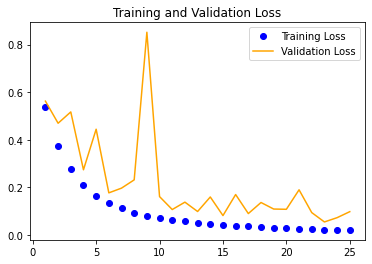

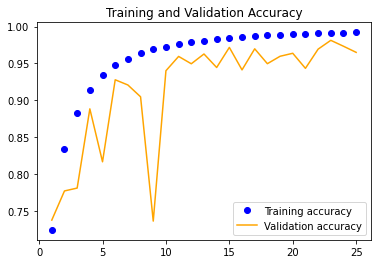

In [12]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [13]:
test_flow = image_gen1.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle = False,
    class_mode='binary'
)
y_pred=model.predict(test_flow)
y_test = test_flow.classes

Found 20000 images belonging to 2 classes.


In [14]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("AP Score:", average_precision_score(y_test, y_pred))
print("Confusion Matrix : \n" ,confusion_matrix(y_test, y_pred>0.5))
print()
print(classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.994876985
AP Score: 0.9947744490609517
Confusion Matrix : 
 [[9655  345]
 [ 324 9676]]

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10000
           1       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



# Saving the model

In [15]:
model.save("densenet169.h5")